In [63]:
import numpy as np
from GaussianProcess import GaussianProcess
from Covariance import GaussianCovariance
from UncertaintyPropagation import (UncertaintyPropagationApprox,
                                    UncertaintyPropagationExact,
                                    UncertaintyPropagationMC, 
                                    UncertaintyPropagationNumericalHG)
from InverseUncertaintyPropagation import InverseUncertaintyPropagationApprox


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Preparing some parameters (just to create the example data)
x = np.array([[x1,x2] for x1 in range(10) for x2 in range(10)]) # 2d sim input (no need to be a neat grid in practice)
w = np.array([0.04,0.04])   # GP bandwidth parameter
v = 2                       # GP variance parameter
vt = 0.01                   # GP variance of the error epsilon

# Preparing the parameter vector
theta = np.zeros(2+len(w))
theta[0] = np.log(v)  # We actually use the log of the parameters as it is easier to optimize (no > 0 constraint etc.)
theta[1] = np.log(vt)
theta[2:2+len(w)] = np.log(w)

# Simulating simulation data by drawing data from a random Gaussian process
t = GaussianProcess.get_realisation(x, GaussianCovariance(),theta)

# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x, t,GaussianCovariance());

[-1.32870502 -2.71499938 -3.00815479 -3.00815479]
l_bfgs_b 	 0.07371783256530762 	 -43.1628594383 	 [-0.09504797 -4.3406061  -2.86822543 -3.053352  ]
[-0.09504797 -4.3406061  -2.86822543 -3.053352  ]


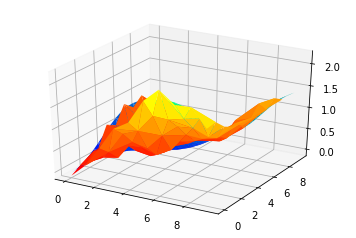

In [65]:
# Getting some values from the regression GP for plotting
x_new = np.array([[x1/2.0,x2/2.0] for x1 in range(20) for x2 in range(20)])
means, variances = gp_est.estimate_many(x_new)

# Plotting the output

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x.T[0],x.T[1],t, cmap=cm.autumn, linewidth=0.2)
ax.plot_trisurf(x_new.T[0],x_new.T[1],means, cmap=cm.winter, linewidth=0.2)
plt.show()

### Uncertainty Propagation

In [70]:
#####################################
# Approximate
#####################################

# Continuing the regression example


# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationApprox(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

0.401269480901 0.000294972800522


In [71]:
# The propagation step
out_mean, out_variance = up.propagate_GA(x_new,Sigma)

ValueError: shapes (2,2) and (400,2) not aligned: 2 (dim 1) != 400 (dim 0)

In [67]:
#####################################
# Exact
#####################################
# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationExact(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

0.401213367713 0.000308722496297


In [68]:
#####################################
# MC
#####################################
# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationMC(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

0.294844854753 0.0144489433386


In [69]:
#####################################
# Numerical HG
#####################################
# The uncertainty to be propagated
mean = np.array([5.0,5.0]) # The mean of a normal distribution
Sigma = np.diag([0.01,0.01]) # The covariance matrix (must be diagonal because of lazy programming)

# Using the gp_est from the regression example
up = UncertaintyPropagationNumericalHG(gp_est)

# The propagation step
out_mean, out_variance = up.propagate_GA(mean,Sigma)

print(out_mean, out_variance)

0.294274829199 0.014503369971


In [46]:
# Continuing the propagation example


# The fisher information matrix for the maximum likelihood estimation of x
# This assumes both components of x to be rate parameters of exponential distributions
I = np.array([1/mean[0]**2,1/mean[1]**2])

# cost vector: the cost for collecting one sample for the estimation of the components of x
c = np.ones(2) # Collecting one sample for each component of x costs 1

# The cost for collecting enough samples to approximately get the Sigma from above (Cramer-Rao-Bound)
print((c/I/np.diag(Sigma)).sum())

# The desired output variance (in this example) is out_variance
# Getting the Sigma that leads to the minimal data collection costs while still yielding out_variance
# If multiple parameters from the same distribution (and therefore the same sample) have to be estimated, we could use the optional parameter "coestimated"
iup = InverseUncertaintyPropagationApprox(out_variance,gp_est,mean,c,I)
Sigma_opt = np.diag(iup.get_best_solution())

# The optimal data collection cost to get the output variance out_variance
print((c/I/np.diag(Sigma_opt)).sum())

# Proof that we actually do get close to out_variance using Sigma_opt
out_mean, out_variance2 = up.propagate_GA(mean,Sigma_opt)
print(out_mean, out_variance2)

5000.0
4197.2239913
-1.33828606261 0.000851968209551
